<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/CI_HW3_CatDogClassifier_Part1_github2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare train and test data (Data Preprocessing)

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

Cloning into 'IUT-CI-HW3-cat-dog-classifier'...
Checking out files: 100% (13/13), done.


In [ ]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/drive/My Drive/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3

Everything is Ok

Folders: 3
Files: 2000
Size:       45739128
Compressed: 45654670

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 13986903 bytes (14 MiB)

Extracting archive: dataset/training_set.zip
--
Path = dataset/training_set.zip
Type = zip
Physical Size = 13986903
Embedded Stub Size = 4
Total Physical Size = 181759063
Multivolum

In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [ ]:
def get_image_shapes(dir,count_limit = 10):
  shapes = {}
  for category in os.listdir(dir):
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      shape = img.shape
      if shape not in shapes:
        shapes[shape] = 1
      else:
        shapes[shape] = shapes[shape] + 1
      
  return sorted(shapes.items(),key=lambda item : -item[1])[:count_limit]

In [ ]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [ ]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      img = cv2.resize(img,(width,height))
      # cv2_imshow(img)
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

In [ ]:
classes = 2
w = 128
h = 128

In [ ]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [ ]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [ ]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [ ]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [ ]:
train_x = np.load('cleanData/train_x.npy')
train_label = np.load('cleanData/train_onehot.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

# Generate basic Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.initializers import RandomNormal

# توضیح کلی در مورد عملکرد این تابع

In [ ]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  history = model.fit(train_x,train_label,
                    batch_size=config['batch'],
                    epochs = config['epochs'],
                    shuffle=True,
                    validation_data=(valid_X,valid_Label))
  
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)

  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])

  return model

# 1- Initial model, Without any dropout and data augmentation

به کمک دراپ‌اوت بصورت تصادفی تعدادی از نرون ها در هر لایه غیرفعال شده و با استفاده از این راه از بیش‌برازش شدن مدل جلوگیری می‌کنیم.



Epoch 1/100
32/32 [==============================] - 7s 84ms/step - loss: 0.6945 - accuracy: 0.5039 - val_loss: 0.6924 - val_accuracy: 0.5144
Epoch 2/100
32/32 [==============================] - 2s 66ms/step - loss: 0.6938 - accuracy: 0.4857 - val_loss: 0.6923 - val_accuracy: 0.5138
Epoch 3/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6928 - accuracy: 0.5084 - val_loss: 0.6924 - val_accuracy: 0.4856
Epoch 4/100
32/32 [==============================] - 2s 66ms/step - loss: 0.6929 - accuracy: 0.5107 - val_loss: 0.6939 - val_accuracy: 0.4856
Epoch 5/100
32/32 [==============================] - 2s 64ms/step - loss: 0.6921 - accuracy: 0.5117 - val_loss: 0.6936 - val_accuracy: 0.4856
Epoch 6/100
32/32 [==============================] - 2s 66ms/step - loss: 0.6929 - accuracy: 0.5155 - val_loss: 0.6940 - val_accuracy: 0.4856
Epoch 7/100
32/32 [==============================] - 2s 66ms/step - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6918 - val_accuracy: 0.5138
Epoch 

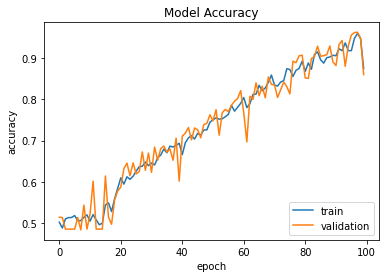

Test loss:  1.7754216194152832
Test accuracy:  0.6209999918937683


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})

Report Precision, Recall and F1-Score

In [ ]:
predictes_classes = model.predict(test_x)
predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(classes)]
print(classification_report(test_vec, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.59      0.78      0.67      1000
     Class 1       0.68      0.46      0.55      1000

    accuracy                           0.62      2000
   macro avg       0.64      0.62      0.61      2000
weighted avg       0.64      0.62      0.61      2000



# تحلیل مدل اولیه

با مقایسه صحت مدل در زمان آموزش و در زمان تست درمی‌یابیم که مدل دچار پیش‌برازش شده است، چرا که در زمان آموزش صحت مدل تا ۹۶ درصد افزایش یافته و در ۸۸ درصد متوقف شده است اما در زمان تست به ۶۲ درصد کاهش یافته است.

برای حل این مشکل میتوانیم:
- از مدل پیچیده تری استفاده کینم
- در تکنیک منظم سازی دراپ‌اوت بهره بگیریم
- به کمک آگمنتیشن تغییراتی در داده های زمان آموزش ایجاد کنیم

در ادامه بوسیله‌ی دو راه حل آخر سعی شده که عملکرد مدل را بهبود دهیم.

# 2- Train model with Dropout Regularization

Epoch 1/100
32/32 [==============================] - 4s 77ms/step - loss: 0.6997 - accuracy: 0.5028 - val_loss: 0.6937 - val_accuracy: 0.4856
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6948 - accuracy: 0.4997 - val_loss: 0.6939 - val_accuracy: 0.4856
Epoch 3/100
32/32 [==============================] - 2s 67ms/step - loss: 0.6940 - accuracy: 0.4954 - val_loss: 0.6927 - val_accuracy: 0.5163
Epoch 4/100
32/32 [==============================] - 2s 69ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6932 - val_accuracy: 0.4819
Epoch 5/100
32/32 [==============================] - 2s 67ms/step - loss: 0.6934 - accuracy: 0.5024 - val_loss: 0.6945 - val_accuracy: 0.4856
Epoch 6/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6935 - accuracy: 0.4981 - val_loss: 0.6919 - val_accuracy: 0.5294
Epoch 7/100
32/32 [==============================] - 2s 67ms/step - loss: 0.6922 - accuracy: 0.5226 - val_loss: 0.6909 - val_accuracy: 0.5506
Epoch 

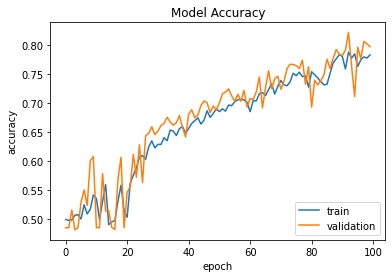

Test loss:  0.7485341429710388
Test accuracy:  0.6299999952316284


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.1,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})

Report Precision, Recall and F1-Score

In [ ]:
predictes_classes = model.predict(test_x)
predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(classes)]
print(classification_report(test_vec, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.61      0.72      0.66      1000
     Class 1       0.66      0.54      0.59      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



# تحلیل عملکرد مدل دوم

در این مدل از شبکه ای مشابه با شبکه مدل قبل استفاده کردیم با این تفاوت که با استفاده از دراپ‌اوت ۱۰ درصد در لایه‌های درونی، بصورت تصادفی ۱۰ درصد از نرون ها غیرفعال شده اند تا از بیش‌بردازش مدل جلوگیری شود.


با وجود اینکه صحت مدل در زمان تست نسبت به حالت اول افزایش یافته است، اما همچنان شاهد آورفیت شدن مدل هستیم چرا که صحت مدل در زمان آموزش و تست فاصله‌ی قابل توجهی دارد.


# 3- Add Data Augmentation(Without dropuot)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs = config['epochs'],
                    )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])

  return model

Epoch 1/100
25/25 [==============================] - 20s 755ms/step - loss: 0.6945 - accuracy: 0.4950 - val_loss: 0.6925 - val_accuracy: 0.5144
Epoch 2/100
25/25 [==============================] - 19s 741ms/step - loss: 0.6940 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.4856
Epoch 3/100
25/25 [==============================] - 19s 742ms/step - loss: 0.6930 - accuracy: 0.5108 - val_loss: 0.6937 - val_accuracy: 0.4856
Epoch 4/100
25/25 [==============================] - 19s 740ms/step - loss: 0.6926 - accuracy: 0.5101 - val_loss: 0.6933 - val_accuracy: 0.4856
Epoch 5/100
25/25 [==============================] - 19s 750ms/step - loss: 0.6929 - accuracy: 0.5206 - val_loss: 0.6936 - val_accuracy: 0.4856
Epoch 6/100
25/25 [==============================] - 19s 747ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.6832 - val_accuracy: 0.5800
Epoch 7/100
25/25 [==============================] - 19s 742ms/step - loss: 0.6902 - accuracy: 0.5347 - val_loss: 0.6917 - val_accuracy:

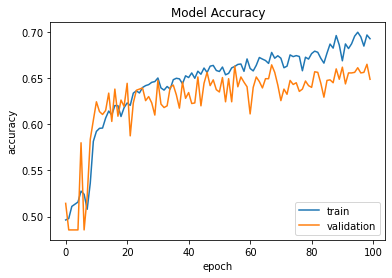

Test loss:  0.6285426616668701
Test accuracy:  0.6464999914169312


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

Report Precision, Recall and F1-Score

In [ ]:
predictes_classes = model.predict(test_x)
predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(classes)]
print(classification_report(test_vec, predicted_classes, target_names = target_names))

# تحلیل عملکرد مدل سوم

مدل سوم و مدل اولیه ساختار شبکه عصبی یکسانی دارند و هر دو از دراپ‌اوت استفاده نکردند،
 اما مدل سوم برخلاف اولین مدل از دادهای آگمنت شده استفاده کرده است. 

 طبق انتظار، این مدل نسبت به مدل اولیه در زمان تست عملکرد بهتری داشته است و به صحت ۶۴ درصد رسیده است، همچنین در این مدل دیگر شاهد آورفیت شدن مدل نیستیم و بین صحت مدل در زمان آموزش و تست تفاوت چشمگیری دیده نمیشود.

 لازم به ذکر است که مدل سوم از دومین مدل عملکرد بهتری دارد.

# 4- Use data augmentation and dropout regularization

Epoch 1/100
25/25 [==============================] - 20s 742ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.4856
Epoch 2/100
25/25 [==============================] - 18s 738ms/step - loss: 0.6938 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.4856
Epoch 3/100
25/25 [==============================] - 18s 734ms/step - loss: 0.6936 - accuracy: 0.4944 - val_loss: 0.6930 - val_accuracy: 0.5425
Epoch 4/100
25/25 [==============================] - 19s 741ms/step - loss: 0.6934 - accuracy: 0.4938 - val_loss: 0.6935 - val_accuracy: 0.4856
Epoch 5/100
25/25 [==============================] - 18s 732ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 6/100
25/25 [==============================] - 18s 732ms/step - loss: 0.6932 - accuracy: 0.5048 - val_loss: 0.6930 - val_accuracy: 0.4988
Epoch 7/100
25/25 [==============================] - 18s 731ms/step - loss: 0.6927 - accuracy: 0.5329 - val_loss: 0.6884 - val_accuracy:

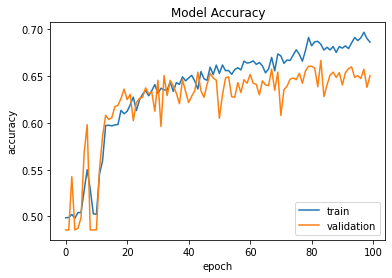

Test loss:  0.6358494162559509
Test accuracy:  0.6449999809265137


In [ ]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

Report: Accuracy, Precision, Recall, F1-measure

In [ ]:
predictes_classes = model.predict(test_x)
predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(classes)]
print(classification_report(test_vec, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.64      0.66      0.65      1000
     Class 1       0.65      0.63      0.64      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.65      0.65      0.64      2000



# تحلیل عملکرد چهارمین مدل

در این قسمت همانند سه مدل قبلی شبکه یکسانی داریم، مشابه مدل دوم از دراپ‌اوت استفاده کرده ایم و مشابه مدل سوم از داده های آگمنت شده برای آموزش مدل استفاده کرده ایم.

در این مدل نیز نسبت به سه مدل قبلی صحت مدل هنگام ارزیابی با داده های تست افزایش یافته است، اگرچه لازم است به این نکته توجه کنیم که درصورت استفاده بیش از انداره از دراپ‌اوت و یا آگمنتیشن مدل آندرفیت شده است و نمیتوانیم به خوبی از قابلیتهای شبکه استفاده کرده و مدل مناسبی آموزش دهیم.